In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement et nettoyage du jeu de données
df = pd.read_csv("../data_fusionnee.csv")
df.columns = df.columns.str.strip().str.replace('"', '').str.replace(r'\t+', '', regex=True)

df.head()

,AN,NO_SEQ_COLL,MS_ACCDN,HR_ACCDN,JR_SEMN_ACCDN,GRAVITE,NB_VICTIMES_TOTAL,NB_VEH_IMPLIQUES_ACCDN,REG_ADM,VITESSE_AUTOR,...,CD_ASPCT_ROUTE,CD_LOCLN_ACCDN,CD_CONFG_ROUTE,CD_ZON_TRAVX_ROUTR,CD_COND_METEO,IND_AUTO_CAMION_LEGER,IND_VEH_LOURD,IND_MOTO_CYCLO,IND_VELO,IND_PIETON
0,2018,2018 _ 1,1,08:00:00-11:59:00,SEM,Dommages matériels seulement,0,2.0,Capitale-Nationale (03),NaN,...,Courbe,99.0,23.0,NaN,12.0,O,N,N,N,N
1,2018,2018 _ 2,1,12:00:00-15:59:00,SEM,Dommages matériels seulement,0,2.0,Montréal (06),NaN,...,Droit,99.0,9.0,NaN,17.0,O,N,N,N,N
2,2018,2018 _ 3,1,12:00:00-15:59:00,SEM,Dommages matériels inférieurs au seuil de rapp...,0,2.0,Montréal (06),50,...,Droit,99.0,1.0,NaN,17.0,N,O,N,N,N
3,2018,2018 _ 4,1,04:00:00-07:59:00,SEM,Dommages matériels inférieurs au seuil de rapp...,0,2.0,Montréal (06),50,...,Droit,99.0,23.0,NaN,17.0,N,O,N,N,N
4,2018,2018 _ 5,1,12:00:00-15:59:00,SEM,Dommages matériels seulement,0,1.0,Chaudière-Appalaches (12),50,...,Droit,99.0,23.0,NaN,11.0,N,O,N,N,N


In [18]:
import pandas as pd
import plotly.graph_objects as go

# Mapping des noms de colonnes en anglais
usager_cols = {
    'IND_AUTO_CAMION_LEGER': 'Light Vehicles',
    'IND_VEH_LOURD': 'Heavy Vehicles',
    'IND_MOTO_CYCLO': 'Motorcycles',
    'IND_VELO': 'Bicycles',
    'IND_PIETON': 'Pedestrians'
}

# Chargement et nettoyage
df[list(usager_cols.keys())] = df[list(usager_cols.keys())].replace({'O': 1, 'N': 0})

# Définir Day/Night selon HR_ACCDN
def classify_period(hr):
    if pd.isna(hr):
        return 'Unknown'
    if hr in ['08:00:00-11:59:00', '12:00:00-15:59:00', '16:00:00-19:59:00']:
        return 'Day'
    elif hr in ['00:00:00-03:59:00', '04:00:00-07:59:00', '20:00:00-23:59:00']:
        return 'Night'
    else:
        return 'Unknown'

df['DAY_NIGHT'] = df['HR_ACCDN'].apply(classify_period)

# Agrégation pour chaque période
data_by_period = {}
for period in ['Day', 'Night']:
    subset = df[df['DAY_NIGHT'] == period]
    counts = subset[list(usager_cols.keys())].sum()
    counts.index = [usager_cols[col] for col in counts.index]
    data_by_period[period] = counts.sort_values(ascending=False)

# Création de la figure interactive
fig = go.Figure()

# Ajout des barres pour Day
fig.add_trace(go.Bar(
    x=data_by_period['Day'].index,
    y=data_by_period['Day'].values,
    name='Day',
    visible=True
))

# Ajout des barres pour Night (masquées par défaut)
fig.add_trace(go.Bar(
    x=data_by_period['Night'].index,
    y=data_by_period['Night'].values,
    name='Night',
    visible=False
))

# Boutons pour interactivité
fig.update_layout(
    title="Number of Accidents by User Type (Day vs Night)",
    xaxis_title="User Type",
    yaxis_title="Number of Accidents",
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            buttons=list([
                dict(label="Day",
                     method="update",
                     args=[{"visible": [True, False]},
                           {"title": "Number of Accidents by User Type - Day"}]),
                dict(label="Night",
                     method="update",
                     args=[{"visible": [False, True]},
                           {"title": "Number of Accidents by User Type - Night"}])
            ]),
            showactive=True,
            x=0.57,
            y=1.15
        )
    ]
)

fig.show()


2. Nombre d’accidents graves impliquant chaque type d’usager

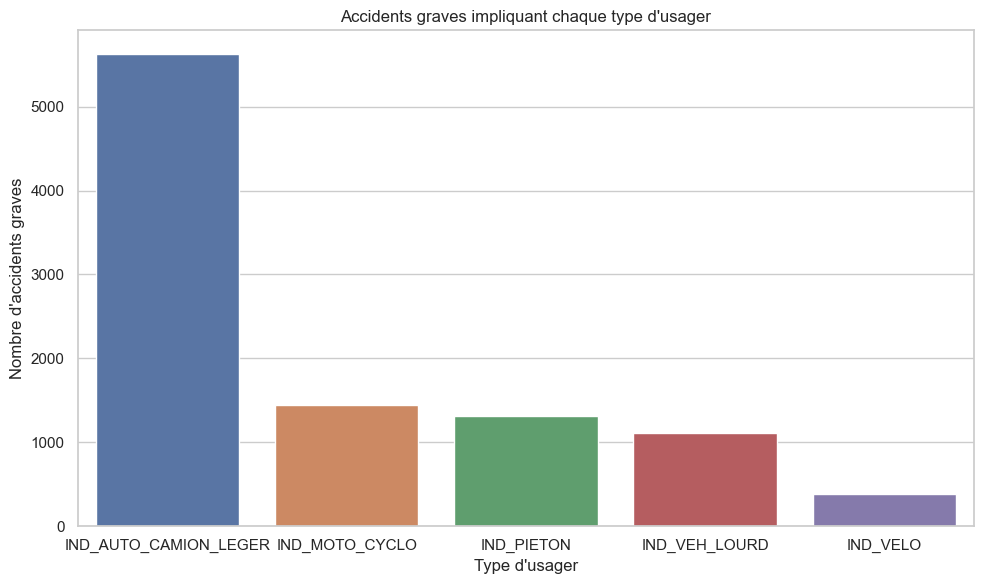

In [6]:
# Filtrage : accidents graves uniquement
df_grave = df[df['GRAVITE'] == 'Mortel ou grave']

# Comptage des usagers impliqués dans les accidents graves
grave_counts = df_grave[usager_cols].sum().sort_values(ascending=False)

# Graphique
plt.figure(figsize=(10, 6))
sns.barplot(x=grave_counts.index, y=grave_counts.values)
plt.title("Accidents graves impliquant chaque type d'usager")
plt.ylabel("Nombre d'accidents graves")
plt.xlabel("Type d'usager")
plt.tight_layout()
plt.savefig("usagers_graves.png")  # Enregistrement
plt.show()


3. Quand surviennent les accidents graves (mois, jour, heure) ?

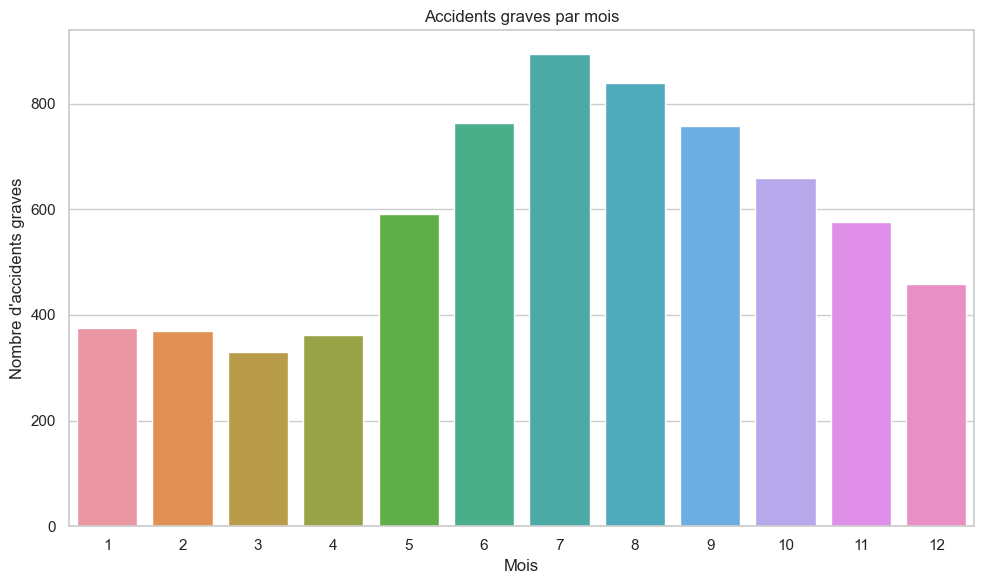

In [7]:
# Répartition des accidents graves par mois
plt.figure(figsize=(10, 6))
sns.countplot(data=df[df['GRAVITE'] == 'Mortel ou grave'], x='MS_ACCDN', order=sorted(df['MS_ACCDN'].dropna().unique()))
plt.title("Accidents graves par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre d'accidents graves")
plt.tight_layout()
plt.savefig("accidents_graves_par_mois.png")
plt.show()


 Par jour de la semaine

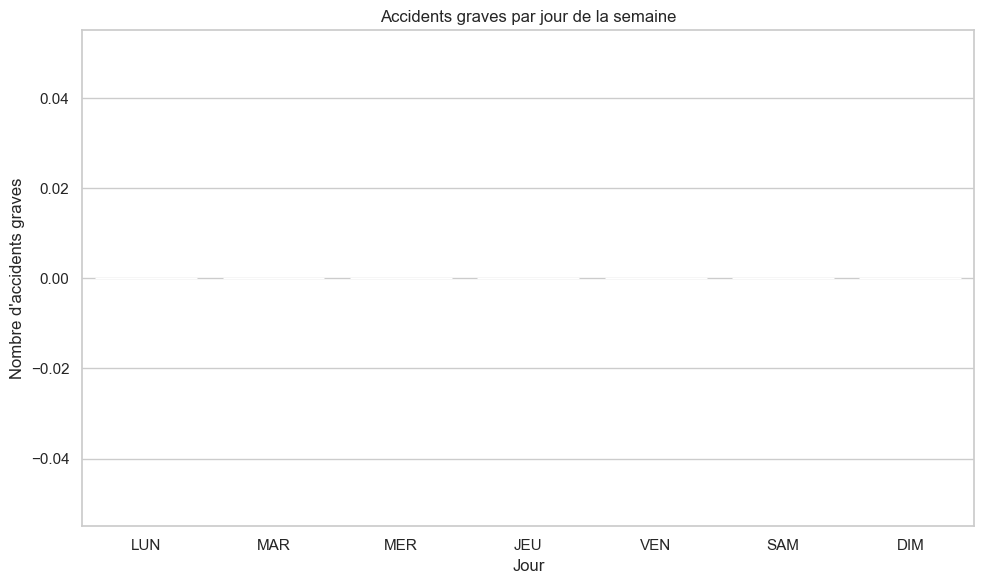

In [8]:
# Ordre des jours (à ajuster si les données sont en abrégé : LUN, MAR, etc.)
jour_order = ['LUN', 'MAR', 'MER', 'JEU', 'VEN', 'SAM', 'DIM']
plt.figure(figsize=(10, 6))
sns.countplot(data=df[df['GRAVITE'] == 'Mortel ou grave'], x='JR_SEMN_ACCDN', order=jour_order)
plt.title("Accidents graves par jour de la semaine")
plt.xlabel("Jour")
plt.ylabel("Nombre d'accidents graves")
plt.tight_layout()
plt.savefig("accidents_graves_par_jour.png")
plt.show()


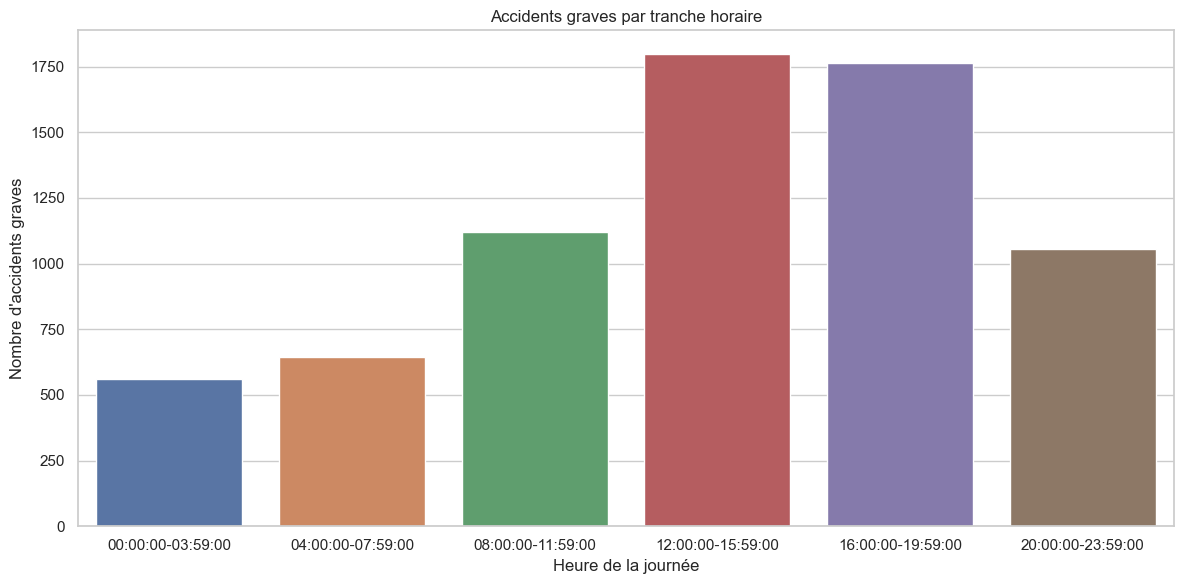

In [9]:
# Répartition des accidents graves par tranche horaire
heure_order = [
    '00:00:00-03:59:00',
    '04:00:00-07:59:00',
    '08:00:00-11:59:00',
    '12:00:00-15:59:00',
    '16:00:00-19:59:00',
    '20:00:00-23:59:00'
]

plt.figure(figsize=(12, 6))
sns.countplot(data=df[df['GRAVITE'] == 'Mortel ou grave'], x='HR_ACCDN', order=heure_order)
plt.title("Accidents graves par tranche horaire")
plt.xlabel("Heure de la journée")
plt.ylabel("Nombre d'accidents graves")
plt.tight_layout()
plt.savefig("accidents_graves_par_heure.png")
plt.show()


4. Où ont lieu les accidents graves au Québec ? (REG_ADM)

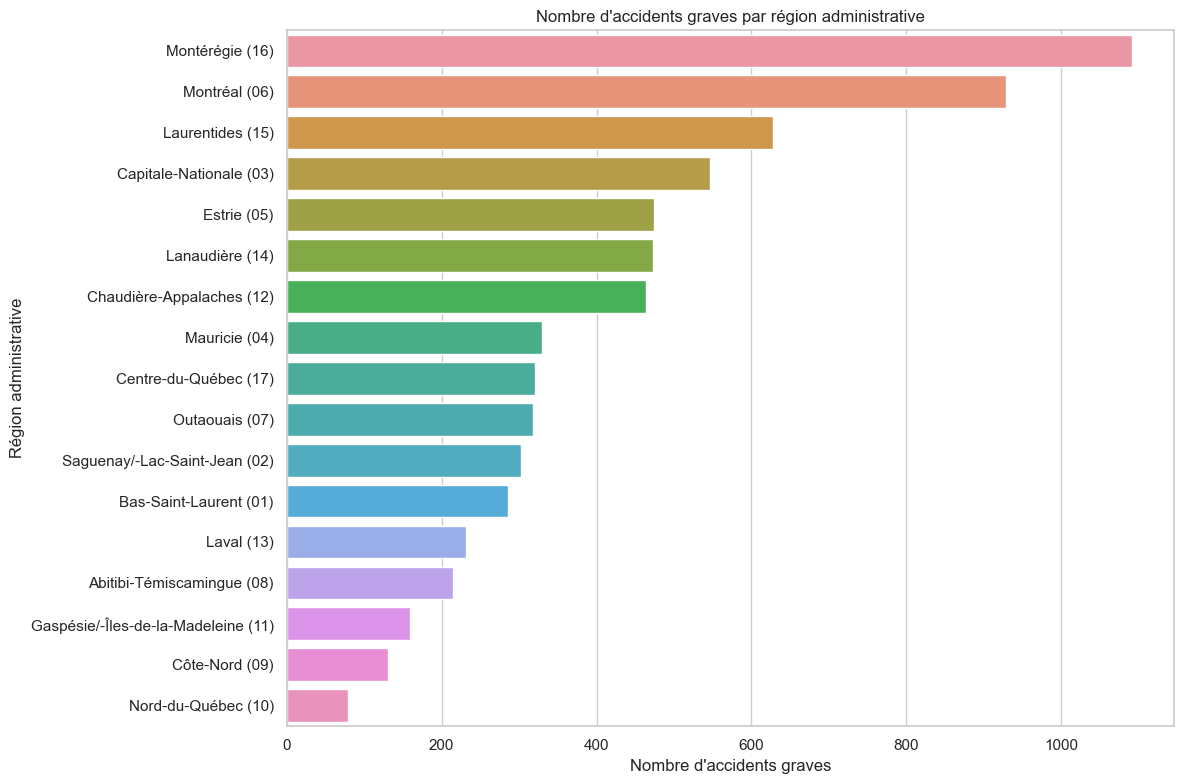

In [10]:
# Suppression des valeurs manquantes de région
df_reg = df[df['GRAVITE'] == 'Mortel ou grave'].dropna(subset=['REG_ADM'])

# Répartition par région
plt.figure(figsize=(12, 8))
region_order = df_reg['REG_ADM'].value_counts().index
sns.countplot(data=df_reg, y='REG_ADM', order=region_order)
plt.title("Nombre d'accidents graves par région administrative")
plt.xlabel("Nombre d'accidents graves")
plt.ylabel("Région administrative")
plt.tight_layout()
plt.savefig("accidents_graves_par_region.png")
plt.show()


 5- Évolution temporelle des accidents graves (AN)

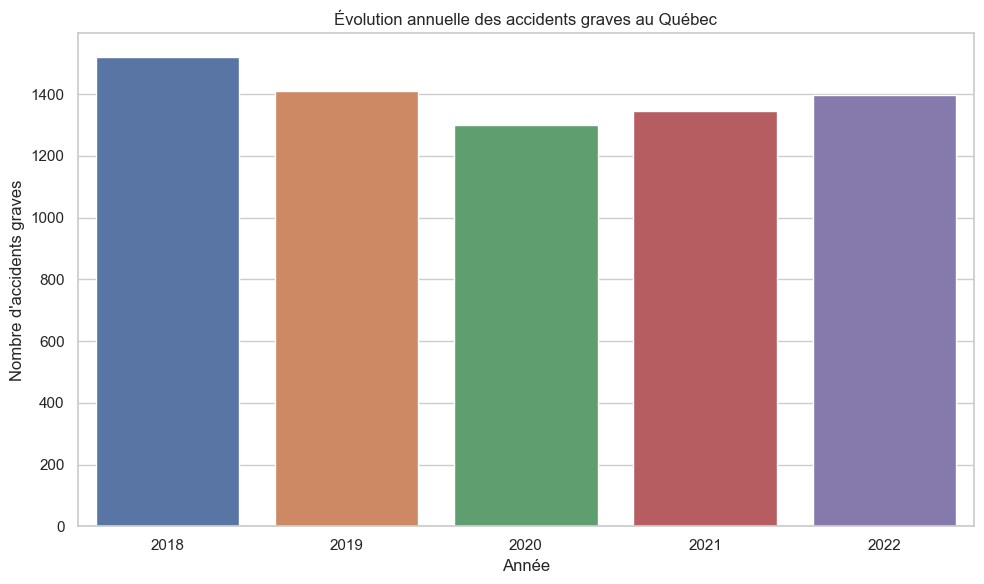

In [11]:
# Répartition par année
plt.figure(figsize=(10, 6))
sns.countplot(data=df[df['GRAVITE'] == 'Mortel ou grave'], x='AN', order=sorted(df['AN'].dropna().unique()))
plt.title("Évolution annuelle des accidents graves au Québec")
plt.xlabel("Année")
plt.ylabel("Nombre d'accidents graves")
plt.tight_layout()
plt.savefig("evolution_accidents_graves_par_annee.png")
plt.show()


6. Distribution des accidents (toutes gravités) par heure de la journée

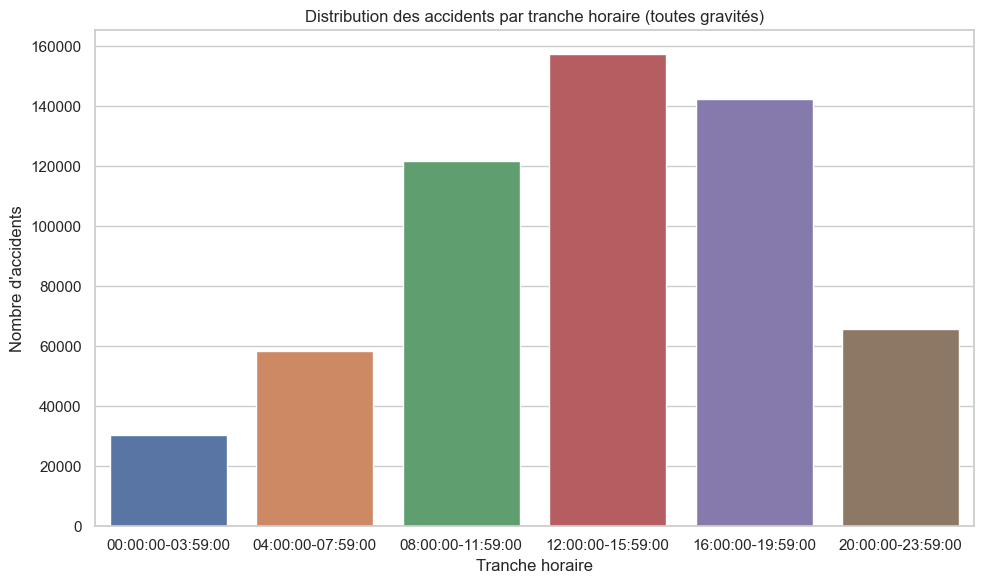

In [12]:
# Distribution des accidents toutes gravités confondues par tranche horaire
heure_order = [
    '00:00:00-03:59:00',
    '04:00:00-07:59:00',
    '08:00:00-11:59:00',
    '12:00:00-15:59:00',
    '16:00:00-19:59:00',
    '20:00:00-23:59:00'
]

plt.figure(figsize=(10, 6))
sns.countplot(data=df.dropna(subset=['HR_ACCDN']), x='HR_ACCDN', order=heure_order)
plt.title("Distribution des accidents par tranche horaire (toutes gravités)")
plt.xlabel("Tranche horaire")
plt.ylabel("Nombre d'accidents")
plt.tight_layout()
plt.savefig("distribution_accidents_par_heure.png")
plt.show()


7. Saisonnalité de la gravité des accidents (par mois et par niveau de gravité)

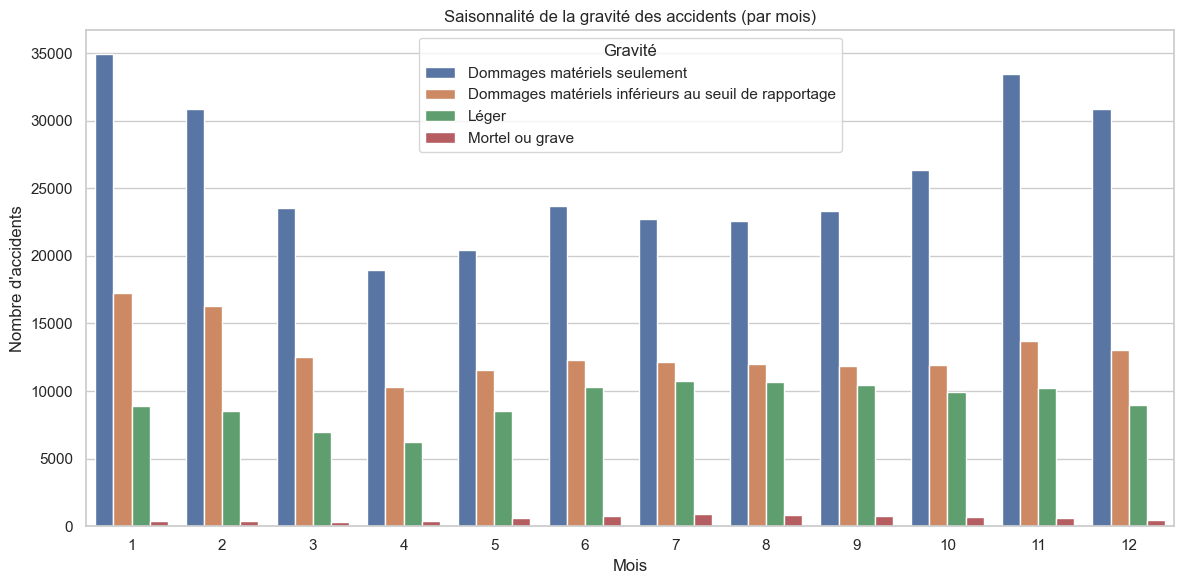

In [13]:
# Suppression des lignes avec mois ou gravité manquante
df_season = df.dropna(subset=['MS_ACCDN', 'GRAVITE'])

plt.figure(figsize=(12, 6))
sns.countplot(data=df_season, x='MS_ACCDN', hue='GRAVITE', order=sorted(df_season['MS_ACCDN'].unique()))
plt.title("Saisonnalité de la gravité des accidents (par mois)")
plt.xlabel("Mois")
plt.ylabel("Nombre d'accidents")
plt.legend(title="Gravité")
plt.tight_layout()
plt.savefig("saisonnalite_gravite_par_mois.png")
plt.show()


1. Heatmap combinée Région × Mois pour les accidents graves

In [26]:
import pandas as pd
import plotly.graph_objects as go

# Mapping mois → abréviations
month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

# Préparation des données
df_grave = df[df['GRAVITE'] == 'Mortel ou grave'].dropna(subset=['REG_ADM', 'MS_ACCDN'])

# Convertir et filtrer les mois
df_grave['MS_ACCDN'] = pd.to_numeric(df_grave['MS_ACCDN'], errors='coerce').astype('Int64')
df_grave = df_grave[df_grave['MS_ACCDN'].between(1, 12)]

# Nettoyage des noms de régions
df_grave['REG_ADM'] = df_grave['REG_ADM'].str.replace(r"\s*\(\d+\)", "", regex=True)

# Pivot table
pivot = df_grave.pivot_table(index='REG_ADM', columns='MS_ACCDN', aggfunc='size', fill_value=0)

# Forcer tous les mois
for m in range(1, 13):
    if m not in pivot.columns:
        pivot[m] = 0

# Réordonner
pivot = pivot[sorted(pivot.columns)]

# Noms formatés pour x et y
x_labels = [month_map[m] for m in pivot.columns]
y_labels = pivot.index.tolist()
z_values = pivot.values

# Construction du texte de hover
hover_text = [[f"{val} severe accidents in {y_labels[i]} during {x_labels[j]}"
               for j, val in enumerate(row)] for i, row in enumerate(z_values)]

# Création de la figure interactive
fig = go.Figure(data=go.Heatmap(
    z=z_values,
    x=x_labels,
    y=y_labels,
    text=hover_text,
    hoverinfo="text",
    colorscale='Reds',
    colorbar=dict(title="Accidents")
))

fig.update_layout(
    title="Severe Accidents by Region and Month (Hover for Details)",
    xaxis_title="Month",
    yaxis_title="Administrative Region",
    width=1200,   
    height=800   
)

fig.show()


2. Graphique multi-facette par moment de la journée et jour de la semaine

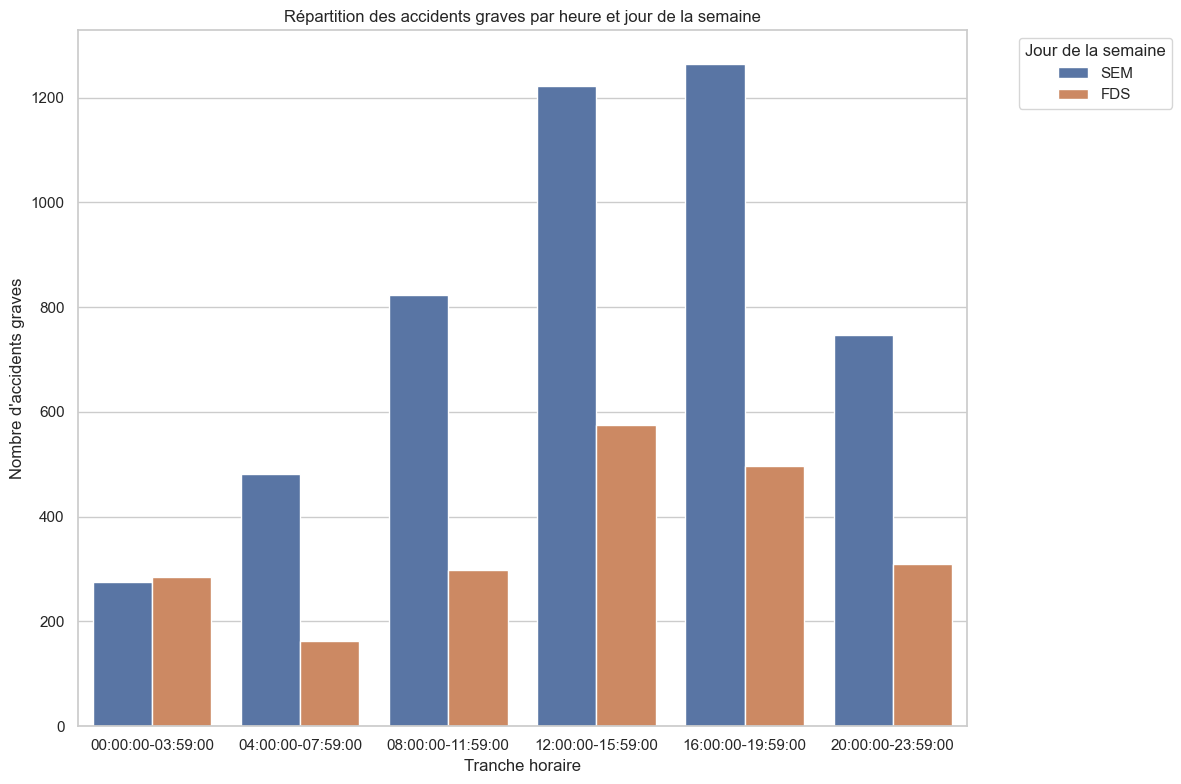

In [15]:
# Préparation
df_grave_time = df[df['GRAVITE'] == 'Mortel ou grave'].dropna(subset=['HR_ACCDN', 'JR_SEMN_ACCDN'])

plt.figure(figsize=(12, 8))
sns.countplot(data=df_grave_time, x='HR_ACCDN', hue='JR_SEMN_ACCDN',
              order=[
                  '00:00:00-03:59:00', '04:00:00-07:59:00',
                  '08:00:00-11:59:00', '12:00:00-15:59:00',
                  '16:00:00-19:59:00', '20:00:00-23:59:00'
              ])
plt.title("Répartition des accidents graves par heure et jour de la semaine")
plt.xlabel("Tranche horaire")
plt.ylabel("Nombre d'accidents graves")
plt.legend(title="Jour de la semaine", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("accidents_graves_heure_jour.png")
plt.show()


3. Ligne temporelle des accidents graves par année (facultatif mais synthétique)

c:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


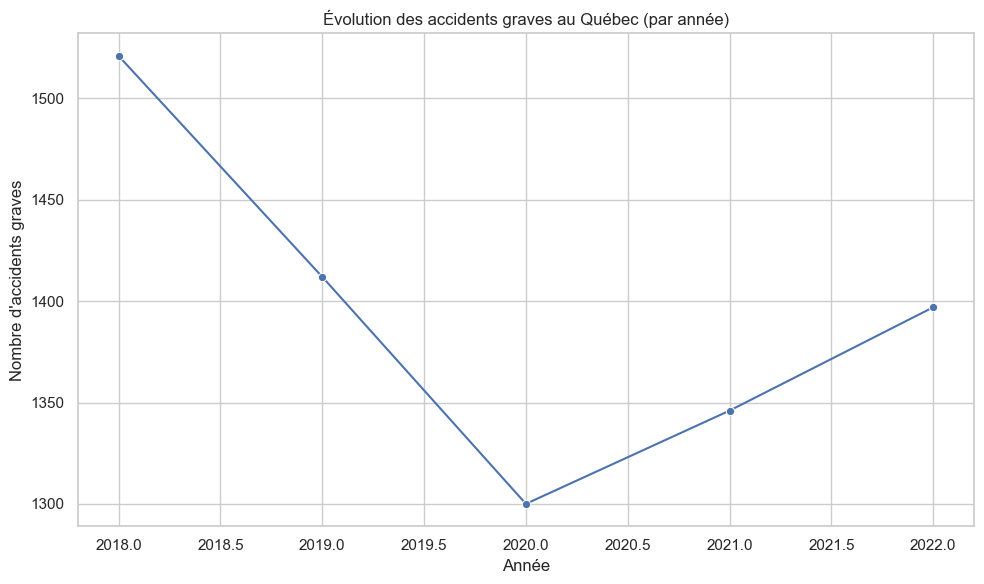

In [16]:
# Évolution annuelle des accidents graves
df_annual = df[df['GRAVITE'] == 'Mortel ou grave'].dropna(subset=['AN'])
yearly_counts = df_annual.groupby('AN').size()

plt.figure(figsize=(10, 6))
sns.lineplot(x=yearly_counts.index, y=yearly_counts.values, marker='o')
plt.title("Évolution des accidents graves au Québec (par année)")
plt.xlabel("Année")
plt.ylabel("Nombre d'accidents graves")
plt.tight_layout()
plt.savefig("evolution_graves_par_annee.png")
plt.show()
